In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pickle
import os
import json

In [3]:
# Cargar los datos
df = pd.read_csv('df_final1.csv')

# Filtrar solo los datos del 2019
df = df[df['year'] == 2019].copy()
print(df.columns)

Index(['entity', 'year', 'schizophrenia_disorders', 'depressive_disorders',
       'anxiety_disorders', 'bipolar_disorders', 'eating_disorders',
       'dalys_depressive_disorders', 'dalys_schizophrenia',
       'dalys_bipolar_disorder', 'dalys_eating_disorders',
       'dalys_anxiety_disorders'],
      dtype='object')


In [4]:
# Definir X y y
X = df.drop(['year', 'anxiety_disorders', 'eating_disorders',
             'dalys_eating_disorders', 'dalys_anxiety_disorders', 'entity'], axis=1)
umbral = df['depressive_disorders'].quantile(0.60)
y = (df['depressive_disorders'] > umbral).astype(int)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir parámetros para búsqueda en cuadrícula
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [5]:
# Crear el modelo base
dtree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# GridSearch
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [6]:
# Predicciones
y_pred = best_model.predict(X_test)
print("\nMejores parámetros:", grid_search.best_params_)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Bajo riesgo', 'Alto riesgo']))
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.4f}")

# Evaluación de overfitting
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
overfitting = train_score - test_score
print("\nAnálisis de Overfitting:")
print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Diferencia: {overfitting:.4f}")
if overfitting > 0.1:
    print("¡Advertencia! El modelo muestra señales de overfitting significativo")
elif overfitting > 0.05:
    print("El modelo muestra señales moderadas de overfitting")
else:
    print("El modelo no muestra señales significativas de overfitting")


Mejores parámetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

Reporte de Clasificación:
              precision    recall  f1-score   support

 Bajo riesgo       0.97      1.00      0.98        31
 Alto riesgo       1.00      0.94      0.97        17

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48

Precisión del modelo: 0.9792

Análisis de Overfitting:
Train Score: 1.0000
Test Score: 0.9792
Diferencia: 0.0208
El modelo no muestra señales significativas de overfitting


## Curva de aprendizaje

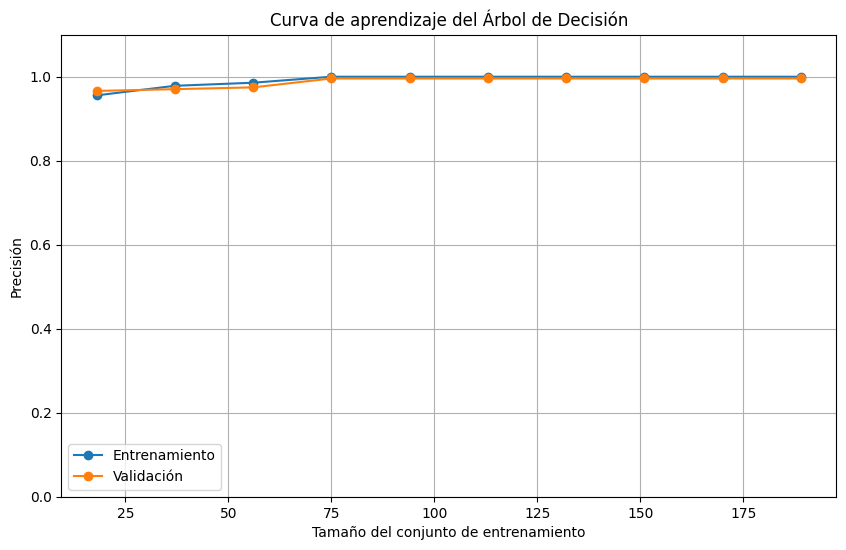

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='accuracy', n_jobs=n_jobs,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim:
        plt.ylim(*ylim)
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.grid()

    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Entrenamiento")
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Validación")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(best_model, "Curva de aprendizaje del Árbol de Decisión", X, y, ylim=(0, 1.1))


## Visualización del árbol

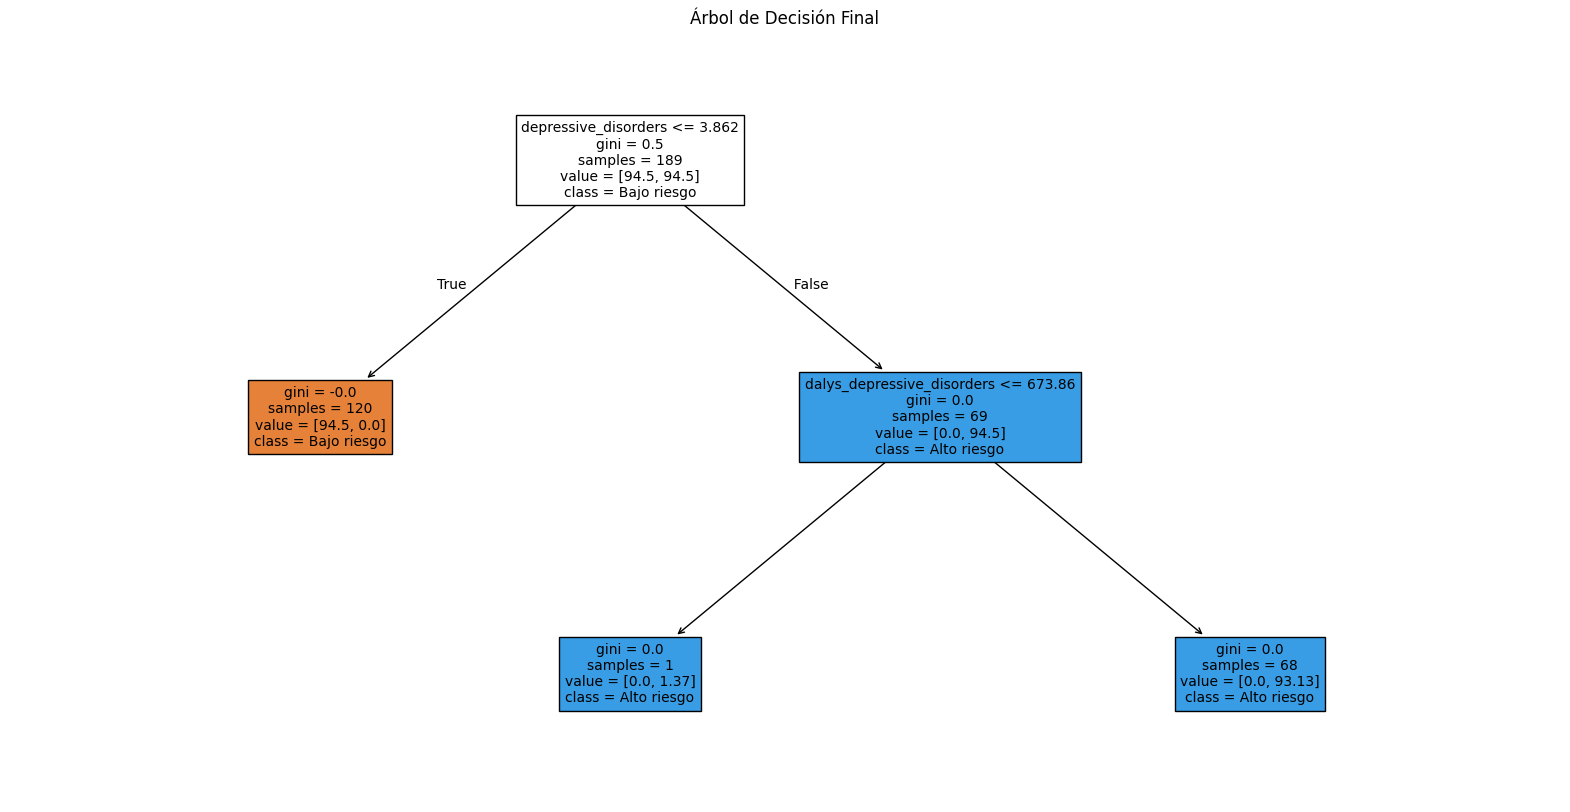

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['Bajo riesgo', 'Alto riesgo'], fontsize=10)
plt.title("Árbol de Decisión Final")
plt.show()

## Importancia de características


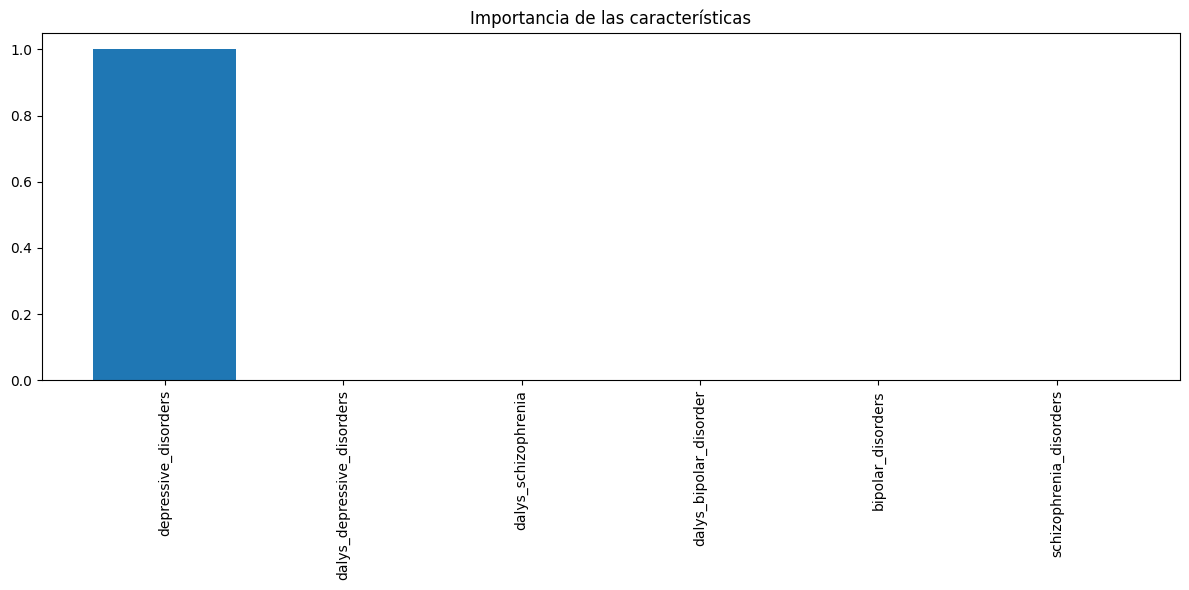

In [9]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()


## Matriz de confusión

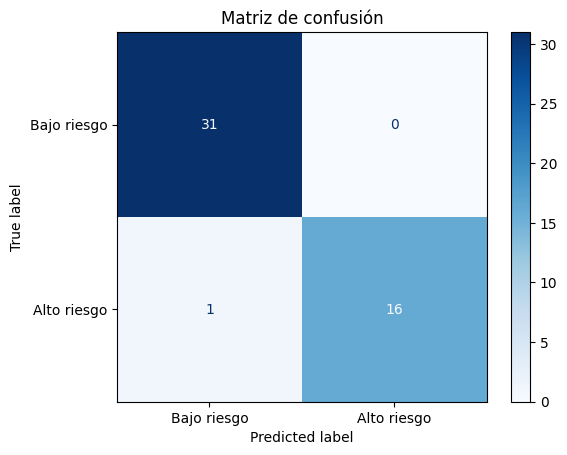

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Bajo riesgo', 'Alto riesgo'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.show()


## Curva ROC

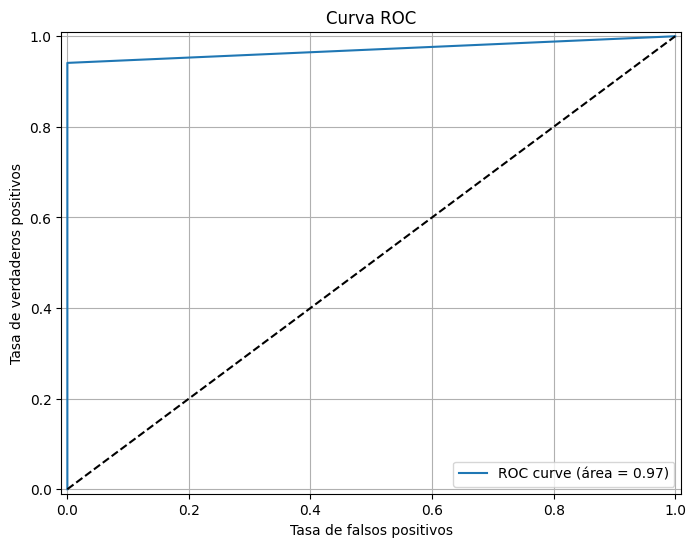

In [11]:
from sklearn.metrics import roc_curve, auc

y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Validación cruzada vs profundidad

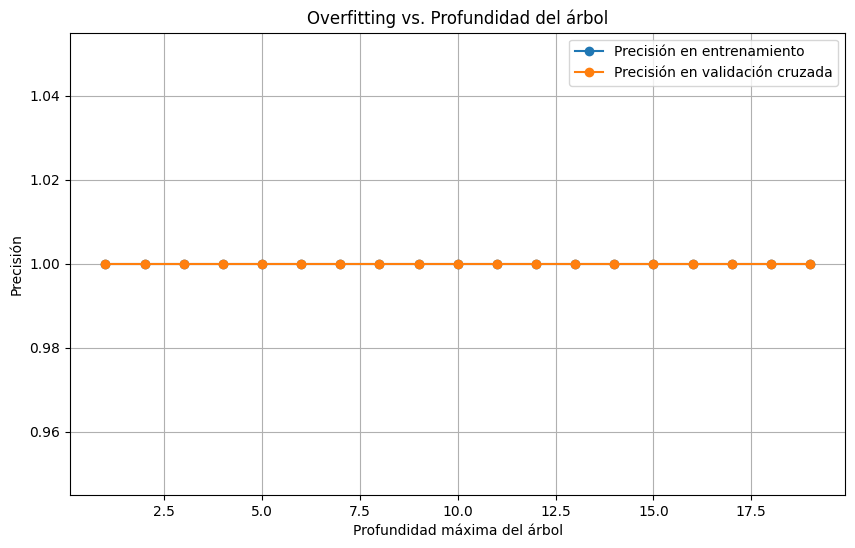

In [12]:
from sklearn.model_selection import cross_val_score

max_depths = range(1, 20)
train_scores = []
cv_scores = []

for d in max_depths:
    model = DecisionTreeClassifier(max_depth=d, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5)))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Precisión en entrenamiento', marker='o')
plt.plot(max_depths, cv_scores, label='Precisión en validación cruzada', marker='o')
plt.xlabel('Profundidad máxima del árbol')
plt.ylabel('Precisión')
plt.title('Overfitting vs. Profundidad del árbol')
plt.legend()
plt.grid(True)
plt.show()


## Mapa de riesgo por país (mapamundi interactivo)

In [18]:
import plotly.express as px

# Crear DataFrame con resultados
df_mapa = df[['entity', 'depressive_disorders']].copy()
df_mapa['riesgo_binario'] = best_model.predict(X)
df_mapa['categoria_riesgo'] = df_mapa['riesgo_binario'].map({0: 'Bajo riesgo', 1: 'Alto riesgo'})

# Cambiar el nombre de columna a 'country' para que plotly lo reconozca
df_mapa = df_mapa.rename(columns={'entity': 'country'})

# Crear mapa interactivo
fig = px.choropleth(
    df_mapa,
    locations='country',
    locationmode='country names',
    color='categoria_riesgo',
    hover_name='country',
    hover_data={'depressive_disorders': True},
    color_discrete_map={
        'Bajo riesgo': 'skyblue',
        'Alto riesgo': 'salmon'
    },
    title='Clasificación de riesgo por país (mapa interactivo)'
)

fig.update_geos(showcoastlines=True, projection_type='natural earth')
fig.update_layout(legend_title_text='Categoría de Riesgo')
fig.show()


##  Mapa de riesgo por país (gráfico de barras)(top 20)

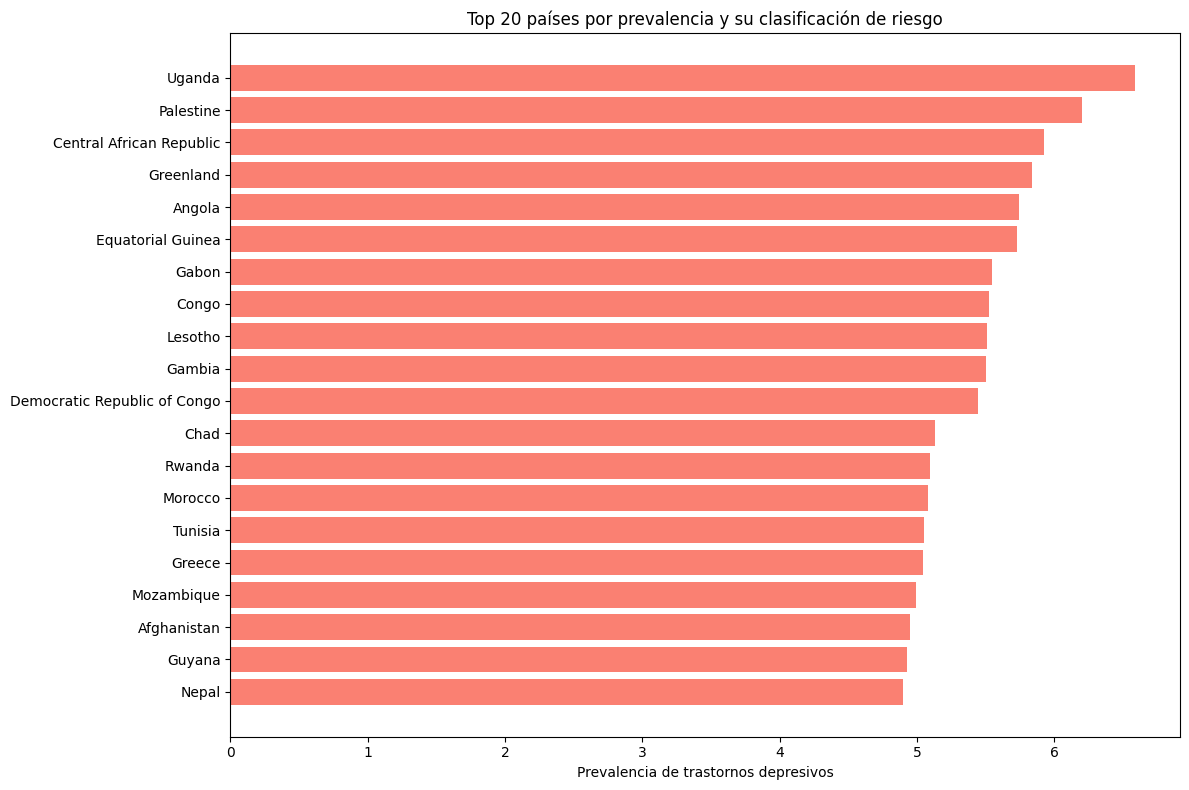

In [17]:
# Crear DataFrame con resultados y entidades
df_resultado = df[['entity', 'depressive_disorders']].copy()
df_resultado['riesgo_binario'] = best_model.predict(X)

# Ordenar por valor de depresión y tomar los 20 países con mayor prevalencia
df_top20 = df_resultado.sort_values(by='depressive_disorders', ascending=False).head(20)

# Graficar
plt.figure(figsize=(12, 8))
colors = df_top20['riesgo_binario'].map({0: 'skyblue', 1: 'salmon'})
plt.barh(df_top20['entity'], df_top20['depressive_disorders'], color=colors)
plt.xlabel('Prevalencia de trastornos depresivos')
plt.title('Top 20 países por prevalencia y su clasificación de riesgo')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Conteo de países por categoría de riesgo

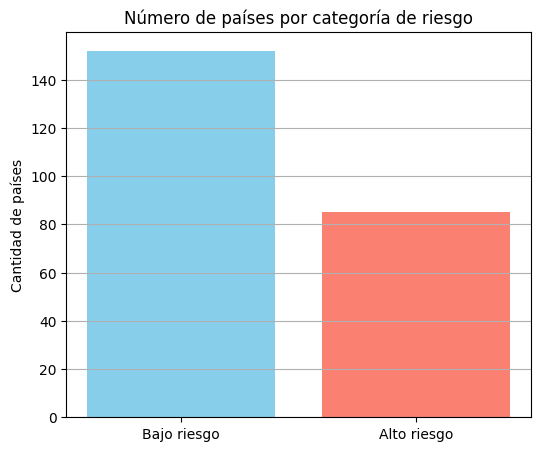

In [15]:
# Conteo de clases
counts = df_resultado['riesgo_binario'].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(['Bajo riesgo', 'Alto riesgo'], counts, color=['skyblue', 'salmon'])
plt.title('Número de países por categoría de riesgo')
plt.ylabel('Cantidad de países')
plt.grid(axis='y')
plt.show()


## Boxplot de prevalencia por grupo de riesgo

<ipython-input-16-d82e6abfab66>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='riesgo_texto', y='depressive_disorders', data=df_resultado, palette=['skyblue', 'salmon'])


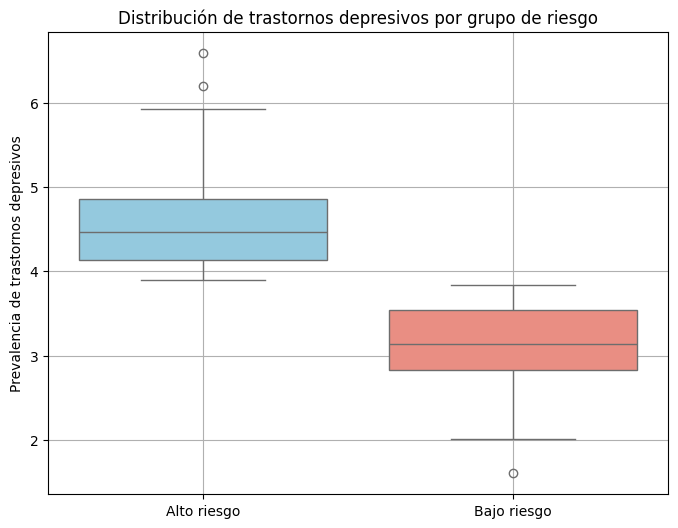

In [16]:
import seaborn as sns

df_resultado['riesgo_texto'] = df_resultado['riesgo_binario'].map({0: 'Bajo riesgo', 1: 'Alto riesgo'})

plt.figure(figsize=(8, 6))
sns.boxplot(x='riesgo_texto', y='depressive_disorders', data=df_resultado, palette=['skyblue', 'salmon'])
plt.title('Distribución de trastornos depresivos por grupo de riesgo')
plt.ylabel('Prevalencia de trastornos depresivos')
plt.xlabel('')
plt.grid(True)
plt.show()


In [13]:
# Guardar modelo
with open("modelo_arbol.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Modelo guardado en modelo_arbol.pkl")

Modelo guardado en modelo_arbol.pkl
